### Задание:

**Необходимо проанализировать и составить отчет по двум независимым экспериментам,
на основании данных и принять решение, какой вариант лучше оставить в сервис: новый
или старый. Советуем при этом опираться на ARPU и вовлечение в функции.
Приветствуется, если первичная обработка данных будет выполнена при помощи SQL, а
сам отчет будет сделан на Руthon, в этом помогут модули рandas, matplotlib и другие.**

**Первый эксперимент предполагает снижение цен на первый продукт с 400 у.е. до 160 у.е.
Второй эксперимент - смена позиций у функций А и Б: А была на позиции function1, а
стала на function2, соответственно, функция Б переместилась с позиции function2 на
function1.**

**Данные представлены в БД МySQL, для подключения используйте информацию ниже.**

**IP: ...  
БД: ...  
User: ...  
Pass: ...**

**Данные находятся в трех таблицах: Action, Ехреreiments и Рауment.**

**_Таблица Action_ содержит данные о совершаемых пользователем событиях и имеет
следующую структуру:**
| uid                            | Ts                             | Action                         |
|:------------------------------:|:------------------------------:|:------------------------------:|
| Идентификатор пользователя     | Время совершения события       | Название события               |

**Событие firstOpen обозначает первое открытие приложения после установки, событие
типа function% отвечает за использование какой-либо функции приложения.**

**_Таблица Ехреriments_ позволяет понять, в какую группу эксперимента попадает
пользователь. Один пользователь может быть в нескольких экспериментах одновременно.**
| Experiment                     | Group                          | uid                            |
|:------------------------------:|:------------------------------:|:------------------------------:|
| Название эксперимента          | Группа в эксперименте          | Идентификатор пользователя     |

**_Таблица Рауment_ содержит информацию о покупках пользователя. В сервисе есть 2 типа
покупок (товара), которые могут быть осуществлены одновременно.**
| uid                            | paymentType                    | Payment                        |
|:------------------------------:|:------------------------------:|:------------------------------:|
| Идентификатор пользователя     | Тип покупки                    | Платеж, который пришел к нам   |

#### Подключение к БД

Устанавливаем mysql-connector-python

In [1]:
# !pip install mysql-connector-python

Проверим

In [2]:
# !pip list

Импортируем необходимые модули

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mysql
import mysql.connector as msql

from scipy import stats

import os

Устанавливаем соединение с БД

In [4]:
conn = msql.connect(os.environ.get("MYSQL_CONNECT"))

Создадим указатель

In [5]:
cur = conn.cursor()

Получим список БД

In [6]:
databases = "show databases"
cur.execute(databases)

for databases in cur:
     print(databases[0])

analytics_test
information_schema
performance_schema


Получим список таблиц в нашей БД

In [7]:
tables = ("show tables from analytics_test")
cur.execute(tables)

for table in cur:
     print(table[0])

Action
Experiments
Payment
events


Посмотрим на данные, для этого выгрузим таблицы в pandas dataframe:
- Action

In [8]:
cur.execute('select * from Action')

Загрузим все данные в объект action

In [9]:
action = cur.fetchall()

Сформируем DataFrame, добавив колонки

In [10]:
df_action = pd.DataFrame(action, columns=[i[0] for i in cur.description])
df_action.head()

uid                  Ts     Action
0  cfjqq 2020-01-16 09:24:32  firstOpen
1  cfjqq 2020-01-16 15:39:41  function2
2  cfjqq 2020-01-16 15:58:21  function4
3  hclau 2020-01-10 22:54:42  firstOpen
4  hclau 2020-01-11 01:19:03  function1

- Experiments

In [11]:
cur.execute('select * from Experiments')

experiments = cur.fetchall()

df_experiments = pd.DataFrame(experiments, columns=[i[0] for i in cur.description])
df_experiments.head()

Experiment Group    uid
0  actionChange   Old  cfjqq
1  actionChange   Old  hclau
2  actionChange   Old  bkhtq
3  actionChange   Old  rxxdh
4  actionChange   Old  ccsko

- Paymentm

In [12]:
cur.execute('select * from Payment')

payments = cur.fetchall()

df_payments = pd.DataFrame(payments, columns=[i[0] for i in cur.description])
df_payments.head()

uid paymentType  Payment
0  hclau       type1      400
1  hclau       type2      200
2  bkhtq       type2      200
3  rxxdh       type2      200
4  qxjhx       type1      400

Сформируем таблицу для анализа гипотезы №1:
- снижение цены на певый продукт с 400 у.е. до 160 у.е. не повлияло на метрики - нулевая гипотеза
- снижение цены на певый продукт с 400 у.е. до 160 у.е. повлияло на метрики - альтернативная гипотеза

In [13]:
cur.execute('''select 
                    a.uid,
                    a.Ts, 
                    a.Action,
                    e.Experiment,
                    e.Group,
                    p.paymentType,
                    p.Payment
               from Action as a
               left join Experiments as e on a.uid = e.uid
               left join Payment as p on e.uid = p.uid
               where e.Experiment = 'paymentChange'
            ''')

table_1 = cur.fetchall()

df_1 = pd.DataFrame(table_1, columns=[i[0] for i in cur.description])
df_1.head()

uid                  Ts     Action     Experiment Group paymentType  \
0  hclau 2020-01-10 22:54:42  firstOpen  paymentChange   Old       type2   
1  hclau 2020-01-10 22:54:42  firstOpen  paymentChange   Old       type1   
2  hclau 2020-01-11 01:19:03  function1  paymentChange   Old       type2   
3  hclau 2020-01-11 01:19:03  function1  paymentChange   Old       type1   
4  hclau 2020-01-11 02:12:33  function2  paymentChange   Old       type2   

   Payment  
0    200.0  
1    400.0  
2    200.0  
3    400.0  
4    200.0

Сформируем таблицу для анализа гипотезы №2:
- смена позиций у функций А и Б не повлияла на метрики - нулевая гипотеза
- смена позиций у функций А и Б повлияла на метрики - альтернативная гипотеза

In [14]:
cur.execute('''select 
                    a.uid, 
                    a.Ts, 
                    a.Action,
                    e.Experiment,
                    e.Group,
                    p.paymentType,
                    p.Payment
               from Action as a
               left join Experiments as e on a.uid = e.uid
               left join Payment as p on e.uid = p.uid
               where e.Experiment = 'actionChange'
            ''')

table_2 = cur.fetchall()

df_2 = pd.DataFrame(table_2, columns=[i[0] for i in cur.description])
df_2.head()

uid                  Ts     Action    Experiment Group paymentType  \
0  hclau 2020-01-10 22:54:42  firstOpen  actionChange   Old       type2   
1  hclau 2020-01-10 22:54:42  firstOpen  actionChange   Old       type1   
2  hclau 2020-01-11 01:19:03  function1  actionChange   Old       type2   
3  hclau 2020-01-11 01:19:03  function1  actionChange   Old       type1   
4  hclau 2020-01-11 02:12:33  function2  actionChange   Old       type2   

   Payment  
0    200.0  
1    400.0  
2    200.0  
3    400.0  
4    200.0

**Первый эксперимент предполагает снижение цены с 400 у.е. до 160 у.е.**

Посмотрим на описательные статистики

In [15]:
df_1.describe()

Ts        Payment
count                         209324  133562.000000
mean   2020-01-15 03:50:04.835728896     213.728755
min              2020-01-09 19:00:27     160.000000
25%              2020-01-12 16:10:13     160.000000
50%       2020-01-15 04:00:08.500000     200.000000
75%       2020-01-17 15:44:48.500000     200.000000
max              2020-01-20 18:50:42     400.000000
std                              NaN      76.653722

Посмотрим на типы данных и пропуски

In [16]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209324 entries, 0 to 209323
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uid          209324 non-null  object        
 1   Ts           209324 non-null  datetime64[ns]
 2   Action       209324 non-null  object        
 3   Experiment   209324 non-null  object        
 4   Group        209324 non-null  object        
 5   paymentType  133562 non-null  object        
 6   Payment      133562 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 11.2+ MB


In [17]:
na_count = df_1.isna().sum()
na_count

uid                0
Ts                 0
Action             0
Experiment         0
Group              0
paymentType    75762
Payment        75762
dtype: int64

In [18]:
print(f'''Вывод:
- в колонках paymentType и Payment наблюдается по {na_count.paymentType} пропущенных значений
- т.е. потенциальные клиенты могли пройти онбординг, пользоваться бесплатным контентом при этом не совершив ни одного платежа
- заполним пропуски в колонке Payment нулями
''')

Вывод:
- в колонках paymentType и Payment наблюдается по 75762 пропущенных значений
- т.е. потенциальные клиенты могли пройти онбординг, пользоваться бесплатным контентом при этом не совершив ни одного платежа
- заполним пропуски в колонке Payment нулями



In [19]:
df_1['Payment'] = df_1.Payment.fillna(0)
df_1.tail()

uid                  Ts     Action     Experiment Group paymentType  \
209319  ylgky 2020-01-13 11:18:35  function4  paymentChange   New       type2   
209320  qdgoa 2020-01-16 16:37:54  firstOpen  paymentChange   New        None   
209321  qdgoa 2020-01-17 04:11:33  function2  paymentChange   New        None   
209322  qdgoa 2020-01-17 06:12:05  function3  paymentChange   New        None   
209323  qdgoa 2020-01-17 02:16:58  function4  paymentChange   New        None   

        Payment  
209319    200.0  
209320      0.0  
209321      0.0  
209322      0.0  
209323      0.0

Выясним есть ли дубликаты

In [20]:
df_1.duplicated().sum()

0

Проверим равны ли выборки по размеру в рамках конкретного эксперимента

In [21]:
size_of_group = df_experiments.query('Experiment == "paymentChange"').Group.value_counts()
size_of_group

Group
Old    25001
New    25000
Name: count, dtype: int64

In [22]:
print(f'''Вывод:
- размеры выборок равны
- и составляют по {size_of_group[1]} уникальных пользователей каждая
''')

Вывод:
- размеры выборок равны
- и составляют по 25000 уникальных пользователей каждая



Проверим что группы Old и New не пересекаются

In [23]:
df_1.query('Group == "Old" and Payment == 160').empty

True

In [24]:
df_1.query('Group == "New" and Payment == 400').empty

True

Количество совершенных транзакций по группам:

In [25]:
count_payment = df_1.Group.value_counts()
count_payment

Group
New    109844
Old     99480
Name: count, dtype: int64

Выясним за какой период собраны данные

In [26]:
df_old = df_1.query('Group == "Old"')

In [27]:
max_date_old, min_date_old = df_old.Ts.dt.date.max(), df_old.Ts.dt.date.min()

In [28]:
exp_period_old = max_date_old - min_date_old
exp_period_old.days

11

In [29]:
df_new = df_1.query('Group == "New"')

In [30]:
max_date_new, min_date_new = df_new.Ts.dt.date.max(), df_new.Ts.dt.date.min()

In [31]:
exp_period_new = max_date_new - min_date_new
exp_period_new.days

11

In [32]:
print(f'Вывод: эксперименты проводились параллельно и заняли {exp_period_new.days} дней')

Вывод: эксперименты проводились параллельно и заняли 11 дней


Рассчитаем средний доход с пользователя (ARPU) для разных групп:

$$ ARPU = {Доход\, за\, период \over Количество\, клиентов}, $$ где  
$$ Доход\, за\, период = {Количество\, проданных\, продуктов \cdot Цена} $$

Количество уникальных клиентов за рассматриваемый период, для группы Old:

In [33]:
count_uniq_old = size_of_group.Old
count_uniq_old

25001

Доход за период для Old:

In [34]:
gross_old = df_1.query('Group == "Old" and Payment != 0').groupby('uid').agg({'Payment': 'sum'}).sum()[0]
gross_old

14254000.0

ARPU Old:

In [35]:
arpu_old = round(gross_old / count_uniq_old)
arpu_old

570

Для группы New:

In [36]:
count_uniq_new = size_of_group.New

gross_new = df_1.query('Group == "New" and Payment ! = 0').groupby('uid').agg({'Payment': 'sum'}).sum()[0]

arpu_new = round(gross_new / count_uniq_new)
arpu_new

572

ARPU по дням

In [37]:
count_uniq_day = df_1.groupby(['Group', df_1.Ts.dt.date])\
                .agg({'uid':'nunique'}).reset_index()\
                .rename(columns={'uid':'Count_customer'})
count_uniq_day.head()

Group          Ts  Count_customer
0   New  2020-01-09             495
1   New  2020-01-10            3032
2   New  2020-01-11            4158
3   New  2020-01-12            4200
4   New  2020-01-13            4402

In [38]:
gross_day = df_1.groupby(['Group', df_1.Ts.dt.date])\
           .agg({'Payment': 'sum'}).reset_index()\
           .rename(columns={'Payment':'Gross_day'})
gross_day.head()

Group          Ts  Gross_day
0   New  2020-01-09   101160.0
1   New  2020-01-10  1152800.0
2   New  2020-01-11  1391760.0
3   New  2020-01-12  1403280.0
4   New  2020-01-13  1434040.0

In [39]:
gross_count_day = count_uniq_day.merge(gross_day, how='inner', on=['Group', 'Ts'])
gross_count_day.head()

Group          Ts  Count_customer  Gross_day
0   New  2020-01-09             495   101160.0
1   New  2020-01-10            3032  1152800.0
2   New  2020-01-11            4158  1391760.0
3   New  2020-01-12            4200  1403280.0
4   New  2020-01-13            4402  1434040.0

In [40]:
gross_count_day['Arpu'] = round(gross_count_day.Gross_day / gross_count_day.Count_customer)
gross_count_day.head()

Group          Ts  Count_customer  Gross_day   Arpu
0   New  2020-01-09             495   101160.0  204.0
1   New  2020-01-10            3032  1152800.0  380.0
2   New  2020-01-11            4158  1391760.0  335.0
3   New  2020-01-12            4200  1403280.0  334.0
4   New  2020-01-13            4402  1434040.0  326.0

Посмотрим на другие платежи пользователей по группам вошедшие в gross_

In [41]:
df_1.Payment.value_counts(dropna=False)

Payment
0.0      75762
200.0    68991
160.0    46169
400.0    18402
Name: count, dtype: int64

In [42]:
df_1.paymentType.value_counts(dropna=False)

paymentType
None     75762
type2    68991
type1    64571
Name: count, dtype: int64

In [43]:
old_200 = df_1.query('Group == "Old" and paymentType == "type2"').Payment.sum()
old_200

6893200.0

In [44]:
new_200 = df_1.query('Group == "New" and paymentType == "type2"').Payment.sum()
new_200

6905000.0

Посчитаем конверсию в покупку

In [45]:
conv_old =\
    round((df_1.query('Group == "Old" and Payment != 0').uid.nunique()\
    / df_1.query('Group == "Old"').uid.nunique()) * 100, 2)
conv_old

49.64

In [46]:
conv_new =\
    round((df_1.query('Group == "New" and Payment != 0').uid.nunique()\
    / df_1.query('Group == "New"').uid.nunique() * 100), 2)
conv_new

68.48

Посчитаем конверсию в покупку по каждому дню

In [47]:
df_conv_all = df_1.groupby(['Group', df_1.Ts.dt.date])\
                .agg({'uid':'nunique'}).reset_index()\
                .rename(columns={'uid':'Count_customer'})
df_conv_all.head()

Group          Ts  Count_customer
0   New  2020-01-09             495
1   New  2020-01-10            3032
2   New  2020-01-11            4158
3   New  2020-01-12            4200
4   New  2020-01-13            4402

In [48]:
df_conv_pay = df_1.query('Payment != 0').groupby(['Group', df_1.Ts.dt.date])\
            .agg({'uid':'nunique'}).reset_index()\
            .rename(columns={'uid':'Count_customer_pay'})
df_conv_pay.head()

Group          Ts  Count_customer_pay
0   New  2020-01-09                 349
1   New  2020-01-10                2116
2   New  2020-01-11                2879
3   New  2020-01-12                2870
4   New  2020-01-13                2969

In [49]:
df_conv = df_conv_all.merge(df_conv_pay, how='inner', on=['Group', 'Ts'])

In [50]:
df_conv['Conversion_pay'] = round((df_conv.Count_customer_pay / df_conv.Count_customer) * 100, 2)

In [51]:
df_conv.head()

Group          Ts  Count_customer  Count_customer_pay  Conversion_pay
0   New  2020-01-09             495                 349           70.51
1   New  2020-01-10            3032                2116           69.79
2   New  2020-01-11            4158                2879           69.24
3   New  2020-01-12            4200                2870           68.33
4   New  2020-01-13            4402                2969           67.45

Вовлеченность в функции

In [52]:
func = df_1.groupby('Group').Action.value_counts()
func

Group  Action   
New    firstOpen    29678
       function3    23783
       function4    23729
       function1    16687
       function2    15967
Old    firstOpen    26851
       function4    21616
       function3    21431
       function1    14978
       function2    14604
Name: count, dtype: int64

In [53]:
df_func = pd.DataFrame(func)
df_func = df_func.rename(columns={'count':'Count'}).reset_index()
df_func

Group     Action  Count
0   New  firstOpen  29678
1   New  function3  23783
2   New  function4  23729
3   New  function1  16687
4   New  function2  15967
5   Old  firstOpen  26851
6   Old  function4  21616
7   Old  function3  21431
8   Old  function1  14978
9   Old  function2  14604

In [54]:
df_func['Conv'] = np.nan

In [55]:
df_func['Conv'] = df_func.query('Group == "Old"').Count / df_func.query('Group == "Old"').Count.sum()

In [56]:
df_func['Conv'] = df_func.Conv.fillna(df_func.query('Group == "New"').Count / df_func.query('Group == "New"').Count.sum())

In [57]:
df_func

Group     Action  Count      Conv
0   New  firstOpen  29678  0.270183
1   New  function3  23783  0.216516
2   New  function4  23729  0.216025
3   New  function1  16687  0.151915
4   New  function2  15967  0.145361
5   Old  firstOpen  26851  0.269914
6   Old  function4  21616  0.217290
7   Old  function3  21431  0.215430
8   Old  function1  14978  0.150563
9   Old  function2  14604  0.146803

Для большей наглядности

In [58]:
df_func_all = df_func[df_func['Group'] == 'New'].merge(df_func[df_func['Group'] == 'Old'],
                                         how='inner', on='Action',
                                         suffixes=('_new', '_old'))
df_func_all

Group_new     Action  Count_new  Conv_new Group_old  Count_old  Conv_old
0       New  firstOpen      29678  0.270183       Old      26851  0.269914
1       New  function3      23783  0.216516       Old      21431  0.215430
2       New  function4      23729  0.216025       Old      21616  0.217290
3       New  function1      16687  0.151915       Old      14978  0.150563
4       New  function2      15967  0.145361       Old      14604  0.146803

In [59]:
df_func_all['Diff_count'] = df_func_all.Count_new - df_func_all.Count_old
df_func_all['Diff_conv'] = round((df_func_all.Conv_new - df_func_all.Conv_old) * 100, 2)
df_func_all

Group_new     Action  Count_new  Conv_new Group_old  Count_old  Conv_old  \
0       New  firstOpen      29678  0.270183       Old      26851  0.269914   
1       New  function3      23783  0.216516       Old      21431  0.215430   
2       New  function4      23729  0.216025       Old      21616  0.217290   
3       New  function1      16687  0.151915       Old      14978  0.150563   
4       New  function2      15967  0.145361       Old      14604  0.146803   

   Diff_count  Diff_conv  
0        2827       0.03  
1        2352       0.11  
2        2113      -0.13  
3        1709       0.14  
4        1363      -0.14

Посчитаем средний чек

In [60]:
df_check = df_1[df_1.Payment != 0]

- для Old

In [61]:
df_check_old =\
    round(df_check[df_check['Group'] == 'Old'].Payment.sum() / df_check[df_check['Group'] == 'Old'].Payment.count())
df_check_old

270

- для New

In [62]:
df_check_new =\
    round(df_check[df_check['Group'] == 'New'].Payment.sum() / df_check[df_check['Group'] == 'New'].Payment.count())
df_check_new

177

Сохраним для наглядности полученные результаты в таблицу:

In [63]:
data = {'Group_old': [count_uniq_old, old_200, gross_old, arpu_old, conv_old, df_check_old],
       'Group_new': [count_uniq_new, new_200, gross_new, arpu_new, conv_new, df_check_new]}

In [64]:
conclusion = pd.DataFrame(data, index=['count_user', 'another_payment', 'gross', 'arpu', 'conversion', 'avg_check'])

In [65]:
conclusion = conclusion.astype('float')

In [66]:
conclusion['Difference'] = conclusion.Group_old - conclusion.Group_new
conclusion

Group_old    Group_new  Difference
count_user          25001.00     25000.00        1.00
another_payment   6893200.00   6905000.00   -11800.00
gross            14254000.00  14292040.00   -38040.00
arpu                  570.00       572.00       -2.00
conversion             49.64        68.48      -18.84
avg_check             270.00       177.00       93.00

In [67]:
print(f'''Вывод:
- arpu за период {exp_period_new.days} дней в разных версиях продукта практически одинаков и в среднем
равен {(arpu_old + arpu_new) / 2} у.е.
- количество уникальных пользователей в разных версиях продукта, также практически одинаково и равно {count_uniq_new} чел.
- но доход новой версии выше на {gross_new - gross_old} у.е.
- в новой версии траты на другой продукт также выше на {new_200 - old_200} у.е.
- конверсия в покупку в новой версии выше в {round(conv_new / conv_old, 1)} раза
- поэтому не смотря на то, что arpu равны, в долгосрочной перспективе выигрывает новая версия, ее и оставляем
''')   

Вывод:
- arpu за период 11 дней в разных версиях продукта практически одинаков и в среднем
равен 571.0 у.е.
- количество уникальных пользователей в разных версиях продукта, также практически одинаково и равно 25000 чел.
- но доход новой версии выше на 38040.0 у.е.
- в новой версии траты на другой продукт также выше на 11800.0 у.е.
- конверсия в покупку в новой версии выше в 1.4 раза
- поэтому не смотря на то, что arpu равны, в долгосрочной перспективе выигрывает новая версия, ее и оставляем



Проверка гипотезы статистичкски

_Зададим пороговое значение (вероятность ошибки первого рода)_

In [68]:
alpha = 0.05

Выясним является ли распределение нормальным. Если нормальное, для проверки будем использовать Т-тест, в противном случае тест Мана Уитни.

_Посмотрим на распределение глазами_

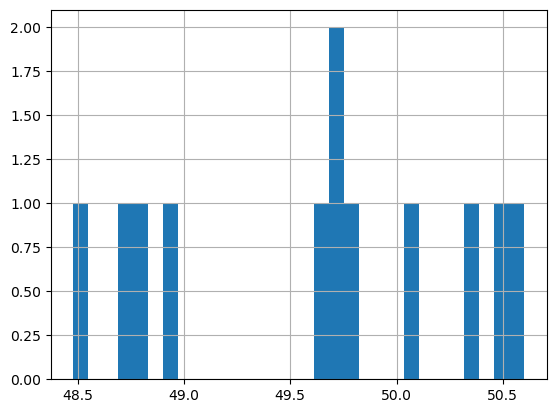

In [69]:
df_conv[(df_conv['Group'] == 'Old')].Conversion_pay.hist(bins=30);

_Проверим распределения на нормальность с помощью теста Шапиро-Уилка_

In [70]:
shapiro_old_conv = stats.shapiro(df_conv[(df_conv['Group'] == 'Old')].Conversion_pay)
shapiro_old_conv

ShapiroResult(statistic=0.9286667108535767, pvalue=0.3661944270133972)

In [71]:
shapiro_new_conv = stats.shapiro(df_conv[(df_conv['Group'] == 'New')].Conversion_pay)
shapiro_new_conv

ShapiroResult(statistic=0.9422399401664734, pvalue=0.5276243686676025)

Вывод:  
Т.к. проверяем на нормальность, значит у нас не должно быть оснований отвергнуть нулевую гипотезу, которая гласит, что распределение является нормальным. Оснований отвергнуть нулевую гипотезу нет когда, полученное значение pvalue больше порогового, в нашем случае это 0.05.  
В обоих распределениях полученное значение pvalue больше чем 0.05. Следовательно нет оснований отклонить нулевую гипотезу. Распределения - нормальные. Можем использовать тест Стюдента для сравнения распределений.

In [72]:
t_test = stats.ttest_ind(df_conv[(df_conv['Group'] == 'Old')].Conversion_pay,
                         df_conv[(df_conv['Group'] == 'New')].Conversion_pay, equal_var=False)
t_test

Ttest_indResult(statistic=-56.991487379588776, pvalue=2.00035563989137e-24)

In [73]:
print(f'p-value: {t_test[1]}')

p-value: 2.00035563989137e-24


In [74]:
print('Вывод:', 'наблюдаемые изменения стат. значимы. Принимаем новую версию продукта' if t_test[1] < alpha\
else 'наблюдаемые изменения носят случайный характер. Оставляем старую версию продукта')

Вывод: наблюдаемые изменения стат. значимы. Принимаем новую версию продукта


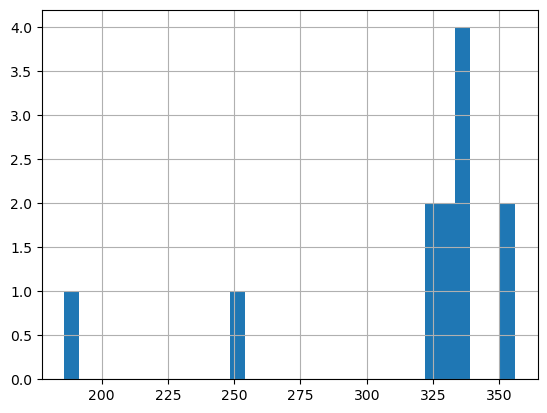

In [75]:
gross_count_day[(gross_count_day['Group'] == 'Old')].Arpu.hist(bins=30);

In [76]:
shapiro_old_arpu = stats.shapiro(gross_count_day[(gross_count_day['Group'] == 'Old')].Arpu)
shapiro_old_arpu

ShapiroResult(statistic=0.6694316864013672, pvalue=0.0004345540073700249)

In [77]:
shapiro_new_arpu = stats.shapiro(gross_count_day[(gross_count_day['Group'] == 'New')].Arpu)
shapiro_new_arpu

ShapiroResult(statistic=0.7420216798782349, pvalue=0.0022087504621595144)

Вывод:  
В обоих распределениях полученное значение pvalue меньше чем 0.05.  
Следовательно есть все основания, чтобы отклонить нулевую гипотезу. Распределения не являются нормальными. Можем использовать тест Мана-Уитни для сравнения распределений.

In [78]:
m_test = stats.mannwhitneyu(gross_count_day[(gross_count_day['Group'] == 'Old')].Arpu,
                           gross_count_day[(gross_count_day['Group'] == 'New')].Arpu)
m_test

MannwhitneyuResult(statistic=73.5, pvalue=0.9538089913655627)

In [79]:
print('Вывод:', 'наблюдаемые изменения стат. значимы. Принимаем новую версию продукта' if m_test[1] < alpha\
else 'наблюдаемые изменения носят случайный характер. Оставляем старую версию продукта')

Вывод: наблюдаемые изменения носят случайный характер. Оставляем старую версию продукта


Рекомендации:
- поэкспериментировать с ценой первого продукта (меньше/больше 160)
- поэкспериментировать с ценами других продуктов (меньше/больше 200)
- добавление нового функционала

**Второй эксперимент - смена позиций у функций. Поменяли местами function1 с function2.**

Проверим размер выборок

In [80]:
df_action.Action.value_counts()

Action
firstOpen    50001
function4    40102
function3    40030
function2    27585
function1    27471
Name: count, dtype: int64

In [81]:
size_func1 = df_action.query('Action == "function1"').uid.nunique()
size_func1

27471

In [82]:
size_func2 = df_action.query('Action == "function2"').uid.nunique()
size_func2

27585

In [83]:
print(f'''Вывод:
- размеры выборок равны
- и составляют в среднем по {int((size_func1 + size_func2) / 2)} уникальных пользователей каждая
''')

Вывод:
- размеры выборок равны
- и составляют в среднем по 27528 уникальных пользователей каждая



Выясним за какой период собраны данные для разных функций

In [84]:
df_2.Experiment.value_counts()

Experiment
actionChange    209324
Name: count, dtype: int64

In [85]:
df_func1 = df_2[df_2['Action'] == 'function1']

In [86]:
func1_max, func1_min = df_func1.Ts.dt.date.max(), df_func1.Ts.dt.date.min()

In [87]:
exp_period_func1 = func1_max - func1_min
exp_period_func1.days

11

In [88]:
df_func2 = df_2[df_2['Action'] == 'function2']

func2_max, func2_min = df_func2.Ts.dt.date.max(), df_func2.Ts.dt.date.min()

exp_period_func2 = func2_max - func2_min
exp_period_func2.days

11

In [89]:
print(f'Вывод: эксперименты проводились параллельно и заняли {exp_period_func2.days} дней')

Вывод: эксперименты проводились параллельно и заняли 11 дней


Посмотрим на распределение сессий по датам

In [90]:
df_copy = df_2.copy()

In [91]:
df_copy['Ts'] = df_2.Ts.dt.date

In [92]:
df_copy.Ts.value_counts().sort_index(ascending=False)

Ts
2020-01-20     4789
2020-01-19    19615
2020-01-18    20726
2020-01-17    20934
2020-01-16    20930
2020-01-15    21229
2020-01-14    21004
2020-01-13    20926
2020-01-12    20522
2020-01-11    20608
2020-01-10    16512
2020-01-09     1529
Name: count, dtype: int64

In [93]:
df_2.iloc[df_2.Ts.sort_values().idxmax(), :]

uid                          fgiri
Ts             2020-01-20 18:50:42
Action                   function1
Experiment            actionChange
Group                          New
paymentType                   None
Payment                        NaN
Name: 177255, dtype: object

Вывод:
   - видно, что количество сессий за 2020-01-20 меньше чем в другие дни. Это связано с тем, что данные взяты за не полный день

Вычислим средний DAU для каждой группы и функции

In [94]:
cur.execute('''select 
                    e.Group,
                    a.Action,
                    date(a.Ts) as Day,
                    count(distinct a.uid) as Dau
               from Action as a
               left join Experiments as e on a.uid = e.uid
               left join Payment as p on e.uid = p.uid
               where e.Experiment = 'actionChange'
               group by e.Group, a.Action, date(a.Ts)              
            ''')

table_dau = cur.fetchall()

df_dau = pd.DataFrame(table_dau, columns=[i[0] for i in cur.description])
df_dau.head()

Group     Action         Day   Dau
0   New  firstOpen  2020-01-09   532
1   New  firstOpen  2020-01-10  2532
2   New  firstOpen  2020-01-11  2442
3   New  firstOpen  2020-01-12  2546
4   New  firstOpen  2020-01-13  2497

In [95]:
old_func1_dau = round(df_dau.query('Action == "function1" and Group == "Old"').Dau.mean())
old_func1_dau

206

In [96]:
old_func2_dau = round(df_dau.query('Action == "function2" and Group == "Old"').Dau.mean())
old_func2_dau

2083

In [97]:
new_func1_dau = round(df_dau.query('Action == "function1" and Group == "New"').Dau.mean())
new_func1_dau

2083

In [98]:
new_func2_dau = round(df_dau.query('Action == "function2" and Group == "New"').Dau.mean())
new_func2_dau

215

Вычислим "sticky_factor"

In [99]:
count_uniq_old_func1 = df_2.query('Group == "Old" and Action == "function1" and Ts < "2020-01-20 00:00:00"').uid.nunique()
count_uniq_old_func1

2378

In [100]:
stiсky_factor_old_func1 = round((old_func1_dau / count_uniq_old_func1) * 100, 2)
stiсky_factor_old_func1

8.66

In [101]:
count_uniq_old_func2 = df_2.query('Group == "Old" and Action == "function2" and Ts < "2020-01-20 00:00:00"').uid.nunique()
count_uniq_old_func2

24159

In [102]:
stiсky_factor_old_func2 = round((old_func2_dau / count_uniq_old_func2) * 100, 2)
stiсky_factor_old_func2

8.62

In [103]:
count_uniq_new_func1 = df_2.query('Group == "New" and Action == "function1" and Ts < "2020-01-20 00:00:00"').uid.nunique()
count_uniq_new_func1

24229

In [104]:
stiсky_factor_new_func1 = round((new_func1_dau / count_uniq_new_func1) * 100, 2)
stiсky_factor_new_func1

8.6

In [105]:
count_uniq_new_func2 = df_2.query('Group == "New" and Action == "function2" and Ts < "2020-01-20 00:00:00"').uid.nunique()
count_uniq_new_func2

2512

In [106]:
stiсky_factor_new_func2 = round((new_func2_dau / count_uniq_new_func2) * 100, 2)
stiсky_factor_new_func2

8.56

Вовлеченность в функции

In [107]:
df_2.Action.value_counts()

Action
firstOpen    56529
function4    45345
function3    45214
function1    31665
function2    30571
Name: count, dtype: int64

In [108]:
f1 = df_2.query('Action == "function1"').groupby('Group').agg({'Action':'count'}).reset_index().\
        rename(columns={'Action':'Count_func1'})

In [109]:
f2 = df_2.query('Action == "function2"').groupby('Group').agg({'Action':'count'}).reset_index().\
        rename(columns={'Action':'Count_func2'})

In [110]:
f3 = df_2.query('Action == "function3"').groupby('Group').agg({'Action':'count'}).reset_index().\
        rename(columns={'Action':'Count_func3'})

In [111]:
f4 = df_2.query('Action == "function4"').groupby('Group').agg({'Action':'count'}).reset_index().\
        rename(columns={'Action':'Count_func4'})

In [112]:
f = f1.merge(f2, how='inner', on='Group').merge(f3, how='inner', on='Group').merge(f4, how='inner', on='Group')
f

Group  Count_func1  Count_func2  Count_func3  Count_func4
0   New        28936         2978        23118        23218
1   Old         2729        27593        22096        22127

In [113]:
print(f'''Вывод:
- старой функцией 1 она же новая функция 2, воспользовались в старой версии {f.iloc[1, 1]} и в новой версии {f.iloc[0, 2]} раз
- в новой версии этой функцией воспользовались на {f.iloc[0, 2] - f.iloc[1, 1]} раз больше
- старой функцией 2 она же новая функция 1, воспользовались в старой версии {f.iloc[1, 2]} и в новой версии {f.iloc[0, 1]} раз
- в новой версии этой функцией воспользовались на {f.iloc[0, 1] - f.iloc[1, 2]} раз больше
- в новой версии функцией 1 и 2 пользуются чаще как и функциями 3 и 4, хотя там никаких изменений не было. Вряд ли это 
следствие эксперимента, скорее просто случайность
- касаемо функций 3 и 4, разница в использовании между ними не значительна''')

Вывод:
- старой функцией 1 она же новая функция 2, воспользовались в старой версии 2729 и в новой версии 2978 раз
- в новой версии этой функцией воспользовались на 249 раз больше
- старой функцией 2 она же новая функция 1, воспользовались в старой версии 27593 и в новой версии 28936 раз
- в новой версии этой функцией воспользовались на 1343 раз больше
- в новой версии функцией 1 и 2 пользуются чаще как и функциями 3 и 4, хотя там никаких изменений не было. Вряд ли это 
следствие эксперимента, скорее просто случайность
- касаемо функций 3 и 4, разница в использовании между ними не значительна


Посчитаем консерсии в функции

In [114]:
conv_old_func1, conv_old_func2, conv_old_func3, conv_old_func4 =\
[round((f.iloc[1, i] / df_2.query('Group == "Old"').Action.count()) * 100, 2) for i in range(1, 5)]

In [115]:
conv_new_func1, conv_new_func2, conv_new_func3, conv_new_func4 =\
[round((f.iloc[0, i] / df_2.query('Group == "New"').Action.count()) * 100, 2) for i in range(1, 5)]

In [116]:
data_1 = {'Old':[conv_old_func1, conv_old_func2, conv_old_func3, conv_old_func4],
          'New':[conv_new_func1, conv_new_func2, conv_new_func3, conv_new_func4]}

In [117]:
conclusion_1 = pd.DataFrame(data_1, index=['Conv_function_1', 'Conv_function_2', 'Conv_function_3', 'Conv_function_4']).T
conclusion_1

Conv_function_1  Conv_function_2  Conv_function_3  Conv_function_4
Old             2.67            27.02            21.63            21.66
New            27.00             2.78            21.57            21.66

Сохраним для наглядности полученные результаты в таблицу:

In [118]:
data_2 = {'Old_function1':[f'{old_func1_dau}', f'{stiсky_factor_old_func1}'],
          'Old_function2':[f'{old_func2_dau}', f'{stiсky_factor_old_func2}'],
          'New_function1':[f'{new_func1_dau}', f'{stiсky_factor_new_func1}'],
          'New_function2':[f'{new_func2_dau}', f'{stiсky_factor_new_func1}']}

In [119]:
conclusion_2 = pd.DataFrame(data_2, index=['dau', 'stiсky_factor'])

In [120]:
conclusion_2 = conclusion_2.astype('float')
conclusion_2

Old_function1  Old_function2  New_function1  New_function2
dau                   206.00        2083.00         2083.0          215.0
stiсky_factor           8.66           8.62            8.6            8.6

In [121]:
print(f'''Вывод:
- разница по dau незначительная и составляет для старой функции 1 (новой функции 2) - \
{abs(conclusion_2.iloc[0, 0] - conclusion_2.iloc[0, 3])}
пользователей,
для старой функции 2 (новой функции 1) - {abs(conclusion_2.iloc[0, 1] - conclusion_2.iloc[0, 2])} пользователей
- разница по stiсky_factor нулевая
- поэтому в смене позиций у функций особого смысла нет''')

Вывод:
- разница по dau незначительная и составляет для старой функции 1 (новой функции 2) - 9.0
пользователей,
для старой функции 2 (новой функции 1) - 0.0 пользователей
- разница по stiсky_factor нулевая
- поэтому в смене позиций у функций особого смысла нет


Проверка гипотезы статистически.    
Для определения взаимосвязи между категориальными переменными будем использовать непараметрический тест - Chi-Square.

In [122]:
alpha = 0.05

Создадим для этого таблицу сопряженности

In [123]:
f1_yes = df_2.query('Action == "function1"').groupby('Group')\
        .agg({'uid':'count'}).rename(columns={'uid':'count_yes_f1'})

In [124]:
f1_no = df_2.query('Action != "function1"').groupby('Group')\
        .agg({'uid':'count'}).rename(columns={'uid':'count_no_f1'})

In [125]:
f1_yes_no = f1_yes.merge(f1_no, how='inner', on='Group')

In [126]:
f2_yes = df_2.query('Action == "function2"').groupby('Group')\
        .agg({'uid':'count'}).rename(columns={'uid':'count_yes_f2'})

In [127]:
f2_no = df_2.query('Action != "function2"').groupby('Group')\
        .agg({'uid':'count'}).rename(columns={'uid':'count_no_f2'})

In [128]:
f2_yes_no = f2_yes.merge(f2_no, how='inner', on='Group')

In [129]:
ff = f1_yes_no.merge(f2_yes_no, how='inner', on='Group')
ff

count_yes_f1  count_no_f1  count_yes_f2  count_no_f2
Group                                                      
New           28936        78250          2978       104208
Old            2729        99409         27593        74545

In [130]:
ff1 = ff.loc['New', ['count_yes_f1', 'count_no_f1']].to_list()

In [131]:
ff2 = ff.loc['Old', ['count_yes_f2', 'count_no_f2']].to_list()

In [132]:
table = np.array([ff1, ff2])
table

array([[28936, 78250],
       [27593, 74545]])

In [133]:
chi_square = stats.chi2_contingency(table, correction=False)[1]
chi_square

0.920616387244344

In [134]:
print('Вывод:', 'наблюдаемые изменения стат. значимы. Принимаем новую версию продукта' if chi_square < alpha\
else 'наблюдаемые изменения носят случайный характер. Оставляем старую версию продукта')

Вывод: наблюдаемые изменения носят случайный характер. Оставляем старую версию продукта


Рекомендации:
- от перемены мест функций разницы нет, поэтому следует оставить как было и искать возможные точки роста в другом месте

Закроем соединение с БД

In [135]:
conn.close()